In [4]:
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend
%load_ext autoreload
%autoreload 2

rows = 2
cols = 2
neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
neutral_atom_config = neutral_atom.configuration()
coupling_map = neutral_atom_config.coupling_map

/Users/anthonypolloreno/.pyenv/versions/3.7.4/envs/qaoa_venv/lib/python3.7/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


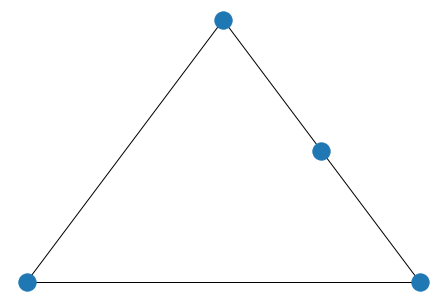

In [5]:
from networkx import Graph, draw_planar
g = Graph(coupling_map)
draw_planar(g)

In [6]:
import numpy as np

np.random.seed(137)
weights = set()
for k in coupling_map:
    weights.add((min(k), max(k)))
# Fix the weights to 1, for now.
weights = {k: 1  for k in weights}

In [7]:
from classical_optimization.qaoa_circuits import maxcut_qaoa_circuit

In [8]:
print(maxcut_qaoa_circuit(gammas=[0,0],betas=[0,0], p=1, weights=weights, rows=rows, cols=cols))

        ┌───┐ ░                                     ░                       »
   q_0: ┤ H ├─░───────■─────────────────────■───────░───────────────────────»
        ├───┤ ░ ┌───┐ │ ┌───┐┌───────┐┌───┐ │ ┌───┐ ░                       »
   q_1: ┤ H ├─░─┤ H ├─■─┤ H ├┤ RZ(0) ├┤ H ├─■─┤ H ├─░───────■───────────────»
        ├───┤ ░ └───┘   └───┘└───────┘└───┘   └───┘ ░       │               »
   q_2: ┤ H ├─░─────────────────────────────────────░───────┼───────────────»
        ├───┤ ░                                     ░ ┌───┐ │ ┌───┐┌───────┐»
   q_3: ┤ H ├─░─────────────────────────────────────░─┤ H ├─■─┤ H ├┤ RZ(0) ├»
        └───┘ ░                                     ░ └───┘   └───┘└───────┘»
meas_0: ════════════════════════════════════════════════════════════════════»
                                                                            »
meas_1: ════════════════════════════════════════════════════════════════════»
                                                                

In [9]:
def produce_gammas_betas(discretization, max_gamma, max_beta):
    return np.linspace(0, max_gamma, discretization), np.linspace(0, max_beta, discretization)

discretization = 20
max_gamma = max_beta = np.pi
gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)

In [10]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
job = execute(experiments, backend=simulator, shots=num_shots)    
all_counts = job.result().get_counts()

In [11]:
from classical_optimization.qaoa_circuits import estimate_cost

landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

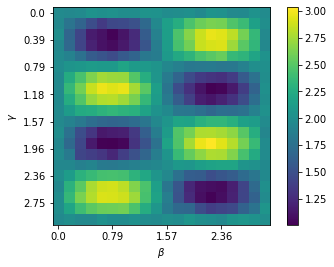

In [12]:
from classical_optimization.qaoa_circuits import plot_landscape

plot_landscape(landscape, max_gamma, max_beta, colorbar=True)

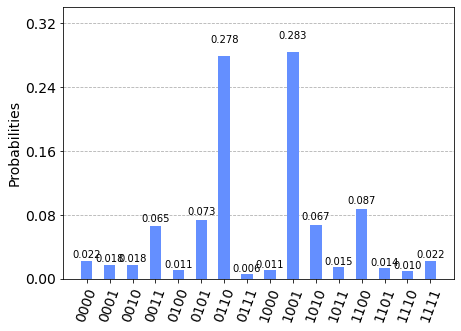

In [13]:
from qiskit.visualization import plot_histogram

plot_histogram(all_counts[np.argmax(landscape)])

# Now introduce noise!

In [14]:
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model

In [15]:
noise_model = create_noise_model()

In [16]:
noise_model = create_noise_model(cz_fidelity=0.7)

experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
job = execute(experiments,
              simulator,
              noise_model=noise_model,
              coupling_map=coupling_map,
              optimization_level=0,
              shots=num_shots)  
all_counts = job.result().get_counts()

In [17]:
noisy_landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        noisy_landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

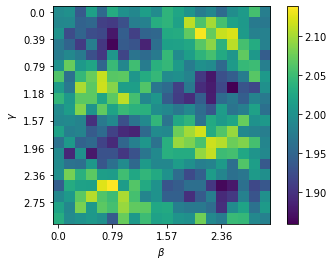

In [18]:
plot_landscape(noisy_landscape, max_gamma, max_beta);

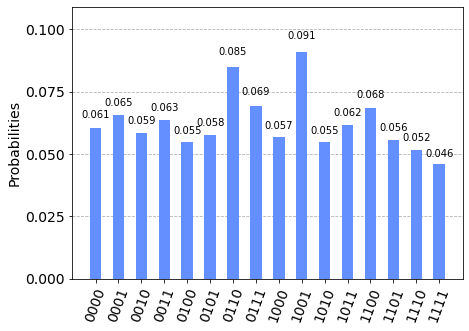

In [19]:
plot_histogram(all_counts[np.argmax(noisy_landscape)])

# Include Classical Optimizer

In [22]:
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
simulator = Aer.get_backend('qasm_simulator')
shots_per_point = 1000

$\gamma$,$\beta$=[0.37789002 0.13685721]
Max cut is 1.812


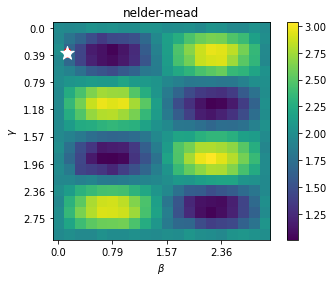

$\gamma$,$\beta$=[2.72436523 0.76336673]
Max cut is 3.026


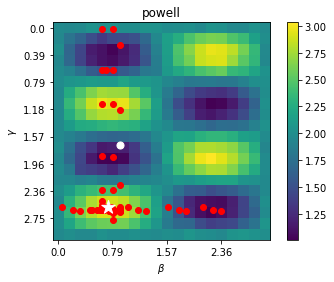

In [33]:
from classical_optimization.qaoa_circuits import try_optimizer
import matplotlib.pyplot as plt

for method in ['nelder-mead', 'powell']:
    history = []
    result = try_optimizer(method, simulator, neutral_atom_config.coupling_map, shots_per_point,
                           weights, max_gamma, max_beta, rows, cols, history)
    history.append(result.x) #We will append the last visited point, since the plotting assumes this is the optimal value.
    plot_landscape(landscape, max_gamma, max_beta, history=history, discretization=discretization)
    plt.title(method)
    plt.show()

## Larger Depths!

In [34]:
discretization = 8
max_gamma = max_beta = np.pi
gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)

In [35]:
import tqdm as tqdm
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        for gamma1 in gammas:
            for beta1 in betas:
                experiments.append(maxcut_qaoa_circuit(gammas=[gamma, gamma1], betas=[beta, beta1], p=2, rows=rows, cols=cols, weights=weights))
job = execute(experiments, backend=simulator, shots=num_shots)    
all_counts = job.result().get_counts()

In [36]:
landscape = np.zeros((discretization, discretization, discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        for k, gamma in enumerate(gammas):
            for l, beta in enumerate(betas):
                landscape[i][j][k][l] = estimate_cost(all_counts[i*len(betas)*len(gammas)*len(betas)+j*len(betas)*len(gammas)+k*len(betas) + l], weights)

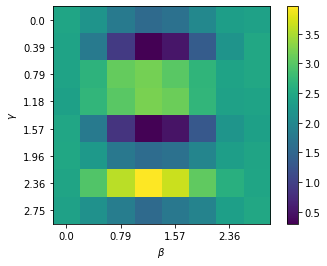

In [38]:
plot_landscape(landscape[np.unravel_index(landscape.argmax(), landscape.shape)[0:2]], max_gamma, max_beta, colorbar=True)

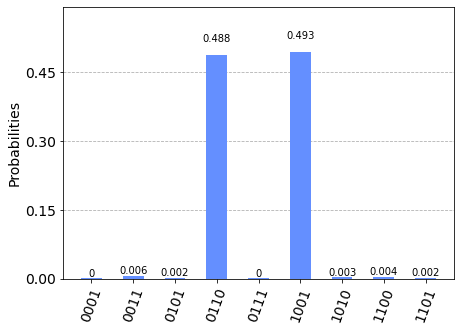

In [39]:
plot_histogram(all_counts[landscape.argmax()])